In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import Point
import numpy as np

# Paths to your FIA files
tree_path = '../data/rfia/CA_TREE.csv'
plot_path = '../data/rfia/CA_PLOT.csv'

# SPCD for Quercus kelloggii
target_spcd = 805


In [2]:
# Load data
tree_df = pd.read_csv(tree_path, low_memory=False)
plot_df = pd.read_csv(plot_path)



In [20]:
# Filter to your species of interest (e.g., SPCD 805 = Quercus kelloggii)
species_spcd = 805
species_trees = tree_df[tree_df["SPCD"] == species_spcd]

# Join with plot coordinates using PLT_CN
species_plots = pd.merge(
    species_trees[['PLT_CN']],
    plot_df[['CN', 'LAT', 'LON']],
    left_on='PLT_CN',
    right_on='CN'
).dropna(subset=['LAT', 'LON']).drop_duplicates()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    species_plots,
    geometry=gpd.points_from_xy(species_plots['LON'], species_plots['LAT']),
    crs='EPSG:4326'
).to_crs('EPSG:32610')  # Reproject to UTM zone 10N

In [21]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np

# Define raster extent and resolution
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
pixel_size = 30
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Define transform
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Create (geometry, value) pairs
shapes = [(geom, 1) for geom in gdf.geometry]

# Rasterize
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)


In [22]:
tif_path = '../data/fia/outputs/quercus_kelloggii_presence_30m.tif'

with rasterio.open(
    tif_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype='uint8',
    crs='EPSG:32610',
    transform=transform
) as dst:
    dst.write(raster, 1)

print(f"Saved presence raster to {tif_path}")


Saved presence raster to ../data/fia/outputs/quercus_kelloggii_presence_30m.tif


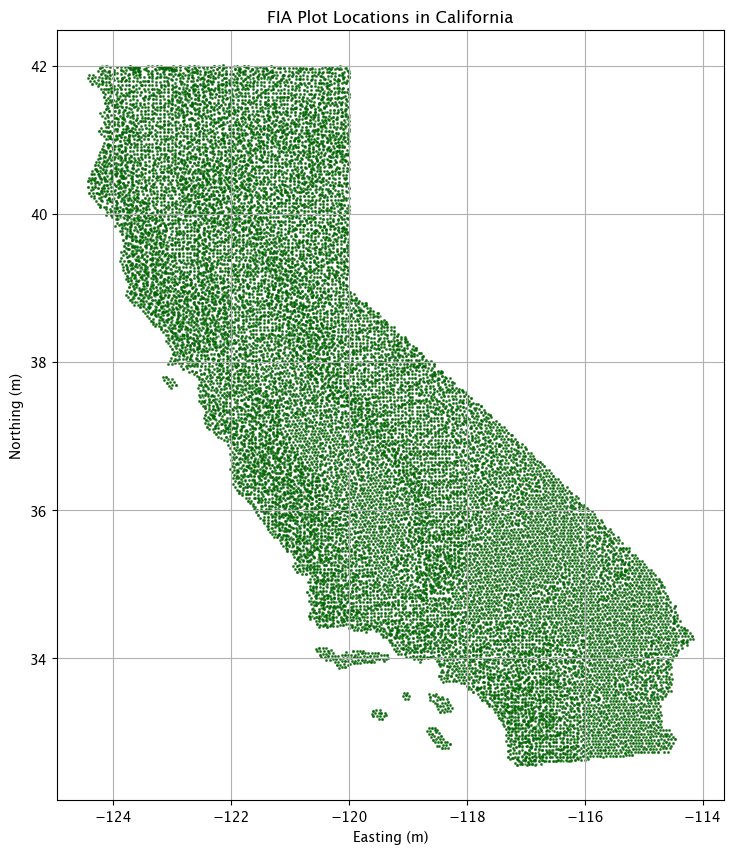

In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Drop missing coordinates
plot_df = plot_df.dropna(subset=['LAT', 'LON'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    plot_df,
    geometry=gpd.points_from_xy(plot_df['LON'], plot_df['LAT']),
    crs='EPSG:4326'
)

# Project to California's UTM zone (optional for later raster work)
gdf = gdf.to_crs("EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=1, alpha=0.5, color='darkgreen')
ax.set_title("FIA Plot Locations in California")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.grid(True)
plt.show()


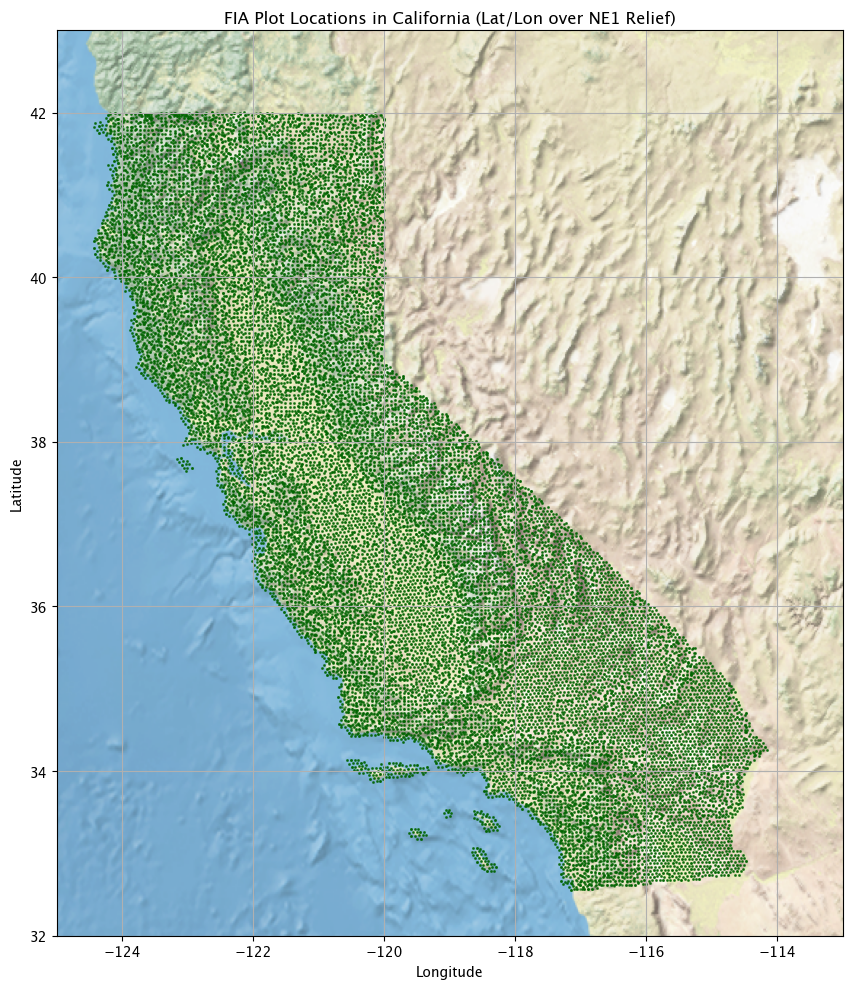

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.warp import transform_bounds


# Convert to GeoDataFrame in EPSG:4326 (WGS84)
fia_gdf = gpd.GeoDataFrame(
    plot_df,
    geometry=gpd.points_from_xy(plot_df["LON"], plot_df["LAT"]),
    crs="EPSG:4326"
)

# Load the NE1 shaded relief raster
raster_path = "../data/NE1_LR_LC_SR_W/NE1_LR_LC_SR_W.tif"
raster = rasterio.open(raster_path)

# Optional: Clip FIA plots to raster bounds for faster plotting
xmin, ymin, xmax, ymax = raster.bounds
fia_clip = fia_gdf.cx[xmin:xmax, ymin:ymax]

# Plot raster + points
fig, ax = plt.subplots(figsize=(12, 10))

# Plot raster background
show(raster, ax=ax)

# Plot FIA points
fia_clip.plot(ax=ax, color="darkgreen", markersize=1, alpha=0.5)

# Set axis limits to California region (adjust as needed)
ax.set_xlim(-125, -113)
ax.set_ylim(32, 43)

ax.set_title("FIA Plot Locations in California (Lat/Lon over NE1 Relief)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


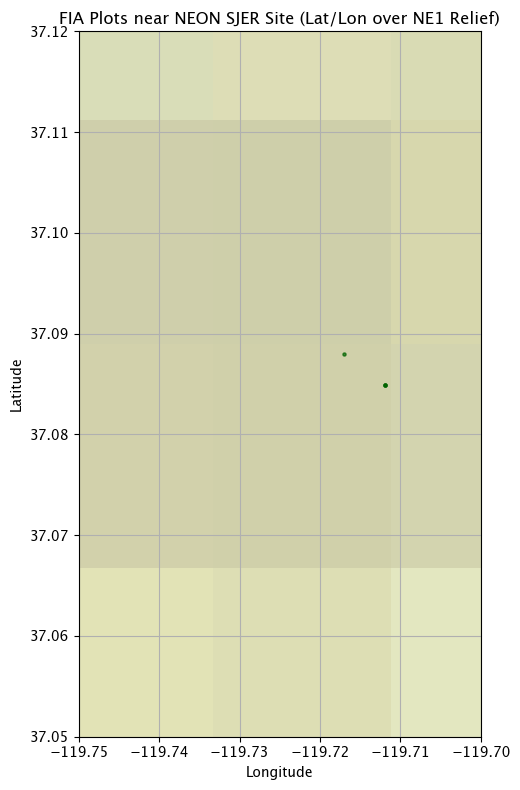

In [46]:

# Define bounding box for SJER in lat/lon
sjer_bbox = {
    "xmin": -119.75,
    "xmax": -119.70,
    "ymin": 37.05,
    "ymax": 37.12
}

# Clip FIA plots to SJER bounding box
fia_sjer = fia_gdf.cx[sjer_bbox["xmin"]:sjer_bbox["xmax"], sjer_bbox["ymin"]:sjer_bbox["ymax"]]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Show background raster (full extent is fine — it’ll be cropped by axes limits)
show(raster, ax=ax)

# Plot FIA points
fia_sjer.plot(ax=ax, color='darkgreen', markersize=5, alpha=0.7)

# Zoom to SJER bbox
ax.set_xlim(sjer_bbox["xmin"], sjer_bbox["xmax"])
ax.set_ylim(sjer_bbox["ymin"], sjer_bbox["ymax"])

ax.set_title("FIA Plots near NEON SJER Site (Lat/Lon over NE1 Relief)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

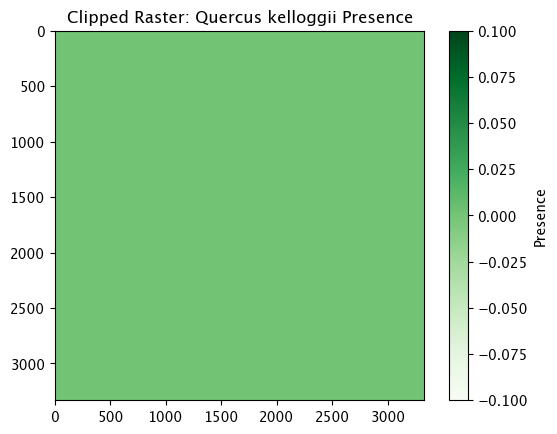

In [26]:
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

# Clip to a small bounding box
with rasterio.open(tif_path) as src:
    # Choose a small area likely to contain presence
    window = from_bounds(bounds[0], bounds[1], bounds[0] + 100000, bounds[1] + 100000, src.transform)
    clipped = src.read(1, window=window)
    transform = src.window_transform(window)

plt.imshow(clipped, cmap='Greens', origin='upper')
plt.title("Clipped Raster: Quercus kelloggii Presence")
plt.colorbar(label="Presence")
plt.show()


In [ ]:
tree_df

,CN,PLT_CN,PREV_TRE_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,SUBP,TREE,...,DRYBIO_STEM,DRYBIO_STEM_BARK,DRYBIO_STUMP_BARK,DRYBIO_BOLE_BARK,DRYBIO_BRANCH,DRYBIO_FOLIAGE,DRYBIO_SAWLOG_BARK,PREV_ACTUALHT_FLD,PREV_HT_FLD,UTILCLCD
0,675267,11839,NaN,1994,6,1,15,1,1,675267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,675268,11839,NaN,1994,6,1,15,1,1,675268,...,NaN,NaN,17.718832,469.383932,NaN,NaN,NaN,NaN,NaN,NaN
2,675269,11839,NaN,1994,6,1,15,1,1,675269,...,NaN,NaN,10.354492,143.559569,NaN,NaN,NaN,NaN,NaN,NaN
3,675270,11839,NaN,1994,6,1,15,1,1,675270,...,NaN,NaN,5.959414,68.141174,NaN,NaN,NaN,NaN,NaN,NaN
4,675271,11839,NaN,1994,6,1,15,1,1,675271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446315,1288145409290487,750085872290487,4.494980e+14,2021,6,6,73,87910,4,312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN
446316,1123911981290487,750085820290487,4.495245e+14,2021,6,6,73,90497,1,303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,65.0,0.0
446317,1123911983290487,750085820290487,NaN,2021,6,6,73,90497,1,324,...,6.108442,3.522788,NaN,NaN,6.677653,10.23776,NaN,NaN,NaN,NaN
446318,1123911987290487,750085820290487,4.495245e+14,2021,6,6,73,90497,4,323,...,711.868776,15.835209,1.488659,14.346550,0.000000,0.00000,NaN,15.0,70.0,NaN


In [17]:
plot_df

,CN,SRV_CN,CTY_CN,PREV_PLT_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,PLOT_STATUS_CD,...,MANUAL_RMRS,PAC_ISLAND_PNWRS,PLOT_SEASON_NERS,PREV_MICROPLOT_LOC_RMRS,PREV_PLOT_STATUS_CD_RMRS,REUSECD1,REUSECD2,REUSECD3,GRND_LYR_SAMPLING_STATUS_CD,GRND_LYR_SAMPLING_METHOD_CD
0,750083723290487,719906686290487,11010497,4.820345e+13,2021,6,5,19,99155,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,750083724290487,719906686290487,11010497,4.820497e+13,2021,6,5,19,97962,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750083725290487,719906686290487,11010497,4.820570e+13,2021,6,5,19,86049,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,750083726290487,719906686290487,55010497,4.820262e+13,2021,6,5,107,71154,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,750083727290487,719906686290487,55010497,4.820463e+13,2021,6,5,107,87080,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43809,558626576126144,532456086126144,26010497,2.988058e+13,2019,6,2,49,81607,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43810,558626577126144,532456086126144,26010497,2.988025e+13,2019,6,2,49,58327,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43811,558626578126144,532456086126144,26010497,NaN,2019,6,2,49,92172,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43812,558626579126144,532456086126144,26010497,2.988033e+13,2019,6,2,49,72357,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
plot_df.columns

Index(['CN', 'SRV_CN', 'CTY_CN', 'PREV_PLT_CN', 'INVYR', 'STATECD', 'UNITCD',
       'COUNTYCD', 'PLOT', 'PLOT_STATUS_CD', 'PLOT_NONSAMPLE_REASN_CD',
       'MEASYEAR', 'MEASMON', 'MEASDAY', 'REMPER', 'KINDCD', 'DESIGNCD',
       'RDDISTCD', 'WATERCD', 'LAT', 'LON', 'ELEV', 'GROW_TYP_CD',
       'MORT_TYP_CD', 'P2PANEL', 'P3PANEL', 'MANUAL', 'KINDCD_NC', 'QA_STATUS',
       'CREATED_DATE', 'MODIFIED_DATE', 'MICROPLOT_LOC', 'DECLINATION',
       'SAMP_METHOD_CD', 'SUBP_EXAMINE_CD', 'MACRO_BREAKPOINT_DIA',
       'INTENSITY', 'CYCLE', 'SUBCYCLE', 'TOPO_POSITION_PNW',
       'NF_SAMPLING_STATUS_CD', 'NF_PLOT_STATUS_CD',
       'NF_PLOT_NONSAMPLE_REASN_CD', 'P2VEG_SAMPLING_STATUS_CD',
       'P2VEG_SAMPLING_LEVEL_DETAIL_CD', 'INVASIVE_SAMPLING_STATUS_CD',
       'INVASIVE_SPECIMEN_RULE_CD', 'DESIGNCD_P2A', 'MANUAL_DB', 'SUBPANEL',
       'FUTFORCD_RMRS', 'MANUAL_NCRS', 'MANUAL_NERS', 'MANUAL_RMRS',
       'PAC_ISLAND_PNWRS', 'PLOT_SEASON_NERS', 'PREV_MICROPLOT_LOC_RMRS',
       'PREV_PLOT_

In [16]:
tree_df

,CN,PLT_CN,PREV_TRE_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,SUBP,TREE,...,DRYBIO_STEM,DRYBIO_STEM_BARK,DRYBIO_STUMP_BARK,DRYBIO_BOLE_BARK,DRYBIO_BRANCH,DRYBIO_FOLIAGE,DRYBIO_SAWLOG_BARK,PREV_ACTUALHT_FLD,PREV_HT_FLD,UTILCLCD
0,675267,11839,NaN,1994,6,1,15,1,1,675267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,675268,11839,NaN,1994,6,1,15,1,1,675268,...,NaN,NaN,17.718832,469.383932,NaN,NaN,NaN,NaN,NaN,NaN
2,675269,11839,NaN,1994,6,1,15,1,1,675269,...,NaN,NaN,10.354492,143.559569,NaN,NaN,NaN,NaN,NaN,NaN
3,675270,11839,NaN,1994,6,1,15,1,1,675270,...,NaN,NaN,5.959414,68.141174,NaN,NaN,NaN,NaN,NaN,NaN
4,675271,11839,NaN,1994,6,1,15,1,1,675271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446315,1288145409290487,750085872290487,4.494980e+14,2021,6,6,73,87910,4,312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN
446316,1123911981290487,750085820290487,4.495245e+14,2021,6,6,73,90497,1,303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,65.0,0.0
446317,1123911983290487,750085820290487,NaN,2021,6,6,73,90497,1,324,...,6.108442,3.522788,NaN,NaN,6.677653,10.23776,NaN,NaN,NaN,NaN
446318,1123911987290487,750085820290487,4.495245e+14,2021,6,6,73,90497,4,323,...,711.868776,15.835209,1.488659,14.346550,0.000000,0.00000,NaN,15.0,70.0,NaN


In [19]:
tree_df.columns

Index(['CN', 'PLT_CN', 'PREV_TRE_CN', 'INVYR', 'STATECD', 'UNITCD', 'COUNTYCD',
       'PLOT', 'SUBP', 'TREE',
       ...
       'DRYBIO_STEM', 'DRYBIO_STEM_BARK', 'DRYBIO_STUMP_BARK',
       'DRYBIO_BOLE_BARK', 'DRYBIO_BRANCH', 'DRYBIO_FOLIAGE',
       'DRYBIO_SAWLOG_BARK', 'PREV_ACTUALHT_FLD', 'PREV_HT_FLD', 'UTILCLCD'],
      dtype='object', length=196)

In [3]:
from rasterio.features import rasterize

# Determine raster bounds
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
pixel_size = 30

# Calculate raster dimensions
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Create raster transform
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Generate (geometry, value) tuples
shapes = [(geom, 1) for geom in gdf.geometry]

# Rasterize
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)


In [6]:
tif_path = '../data/fia/outputs/quercus_kelloggii_presence_30m.tif'

# with rasterio.open(
#     out_path, 'w',
#     driver='GTiff',
#     height=height,
#     width=width,
#     count=1,
#     dtype=raster.dtype,
#     crs='EPSG:32610',
#     transform=transform
# ) as dst:
#     dst.write(raster, 1)

# print(f"Saved to {out_path}")


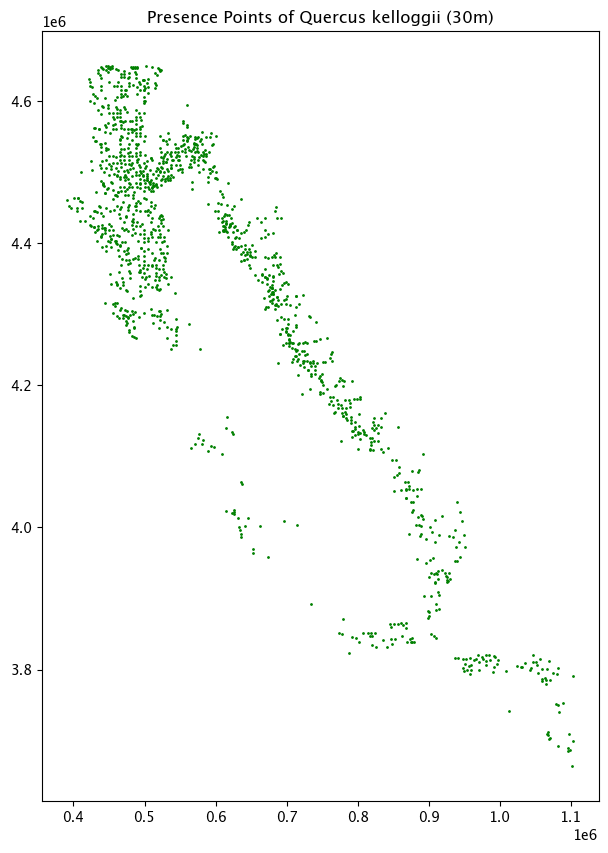

In [13]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import rasterio

points = []

with rasterio.open(tif_path) as src:
    data = src.read(1)
    transform = src.transform

    # Loop only through presence pixels
    rows, cols = np.where(data == 1)
    for row, col in zip(rows, cols):
        x, y = transform * (col + 0.5, row + 0.5)
        points.append(Point(x, y))

gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:32610")

# Plot
gdf.plot(markersize=1, figsize=(10, 10), color='green')
plt.title("Presence Points of Quercus kelloggii (30 m)")
plt.show()
